In [416]:
import os.path

import numpy as np
import random
seed = 42
random.seed(seed)

import warnings
warnings.filterwarnings('ignore')

import mne
from mne import find_events
from mne.decoding import Vectorizer, SlidingEstimator, cross_val_multiscore

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, StratifiedKFold, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, precision_recall_fscore_support, balanced_accuracy_score

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import import_ipynb
from CommonFunctions import loadData, extractDataAndLabels, concatNonEmpty, prepareData_conf_behavior, prepareData_pred_behavior_conf, splitEpochs_byConfidence, loadDataByParticipant

import pylab
import seaborn as sns
from scipy.stats import sem


In [417]:
def applySmoothing(data, N):
    # Initialize smoothed data variable
    data_sm = np.zeros((data.shape[0], data.shape[1]-N+1))
            
    #print('shape of data at 0: ', data_0.shape)
    #print('shape of data_sm_0: ', data_sm_0.shape)

    # Apply smoothing:
    for f in range(len(data_sm)):
        data_sm[f] = np.convolve(data[f,:], np.ones((N,))/N, mode='valid')
    
    return data_sm
    

In [418]:

def plot_conditions(data, peakPoint, times, ylabel, plotname, labels=None, isOmi=True, smooth=False, isReal=False, 
                    isPredLevel=True, includeInverted=False, fvalues=None):
    print(peakPoint)
    sns.set(style="white")
    #ColorsL = np.array(([194,165,207], [153,112,171], [118,42,131]))/256
    ColorsL = np.array(([194,165,207], [118,42,131], [64,0,75], [153,112,171]))/256
    #ColorsL = np.array(([90,174,97], [27,120,55], [118,42,131], [64,0,75]))/256
    col_axes = np.array((82, 82, 82))/256
    pval_color = np.array(([128,128,128]))/256

    al = 0.2
    fig = plt.figure(num=None, figsize=(4, 2), dpi=150)
    ax = fig.add_subplot(1,1,1)
    
    if tmin == -0.8:
        data = data[:,:,70:]
        
    # Check data (results) if the scores are non-zero (IMPORTANT especially for confidence)
    deletion_list = []
    for t_ind in range(data.shape[1]):
        zero_indices = np.where(np.sum(data[:,t_ind,:], axis = 1) == 0)[0]
        zero_indices = zero_indices.tolist()
        if len(zero_indices) > 0:
            print('WARNING: Zero score detected!!')
            print('Index of the subjects with 0 score: ', zero_indices)
            deletion_list.extend(zero_indices)
    
    if len(deletion_list) > 0:
        deletion_list_unique = list(set(deletion_list))
        deletion_list_unique.sort()
        print('deletion indices: ', deletion_list_unique)
        print('BEFORE DELETION: Shape of the data: ', data.shape)
        data = np.delete(data, deletion_list_unique, 0)  
        print('AFTER DELETION: New shape of the data: ', data.shape)
    
        
    N = 10 # Kernel for smoothing
    min_vals = np.zeros((data.shape[1]),)
    
    if isReal == False:
        if smooth == True:
            data_0 = data[:,0,:]
            data_sm_0 = applySmoothing(data_0, N)
            epochs_mean = np.mean(data_sm_0, axis = 0)
            min_vals[0] = np.min(epochs_mean)
            epochs_std = sem(data_sm_0, axis = 0)/2
            
            ax.plot(times[:len(times)-N+1], epochs_mean, color=ColorsL[0], linewidth = 2,  label = labels[0])
            ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean + epochs_std, color=ColorsL[0], interpolate=True, alpha = al)
            ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean - epochs_std, color=ColorsL[0], interpolate=True, alpha = al)

            data_1 = data[:,1,:]
            data_sm_1 = applySmoothing(data_1, N)
            epochs_mean = np.mean(data_sm_1, axis = 0)
            min_vals[1] = np.min(epochs_mean)
            epochs_std = sem(data_sm_1, axis = 0)/2
            
            ax.plot(times[:len(times)-N+1], epochs_mean, color=ColorsL[1], linewidth = 2,  label = labels[1])
            ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean + epochs_std, color=ColorsL[1], interpolate=True, alpha = al)
            ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean - epochs_std, color=ColorsL[1], interpolate=True, alpha = al)

            if isPredLevel == True or includeInverted == True or data.shape[1] > 2:
                data_2 = data[:,2,:]
                data_sm_2 = applySmoothing(data_2, N)
                epochs_mean = np.mean(data_sm_2, axis = 0)
                min_vals[2] = np.min(epochs_mean)
                epochs_std = sem(data_sm_2, axis = 0)/2
                
                ax.plot(times[:len(times)-N+1], epochs_mean, color=ColorsL[2], linewidth = 2,  label = labels[2])
                ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean + epochs_std, color=ColorsL[2], interpolate=True, alpha = al)
                ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean - epochs_std, color=ColorsL[2], interpolate=True, alpha = al)
                
                if data.shape[1] == 4:
                    data_3 = data[:,3,:]
                    data_sm_3 = applySmoothing(data_3, N)
                    epochs_mean = np.mean(data_sm_3, axis = 0)
                    min_vals[3] = np.min(epochs_mean)
                    epochs_std = sem(data_sm_3, axis = 0)/2

                    ax.plot(times[:len(times)-N+1], epochs_mean,  color=ColorsL[3], linewidth = 2,  label = labels[3])
                    ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean + epochs_std, color=ColorsL[3], interpolate=True, alpha = al)
                    ax.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean - epochs_std, color=ColorsL[3], interpolate=True, alpha = al)



        else:
            epochs_mean = np.mean(data[:,0,:], axis = 0)
            epochs_std = sem(data[:,0,:], axis = 0)/2
            
            plt.plot(times, epochs_mean, color = ColorsL[0], linewidth = 2,  label = labels[0])
            plt.fill_between(times, epochs_mean, epochs_mean + epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
            plt.fill_between(times, epochs_mean, epochs_mean - epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
            
            epochs_mean = np.mean(data[:,1,:], axis = 0)
            epochs_std = sem(data[:,1,:], axis = 0)/2
            
            plt.plot(times, epochs_mean, color = ColorsL[0], linewidth = 2,  label = labels[1])
            plt.fill_between(times, epochs_mean, epochs_mean + epochs_std, color = ColorsL[1], interpolate=True, alpha = al)
            plt.fill_between(times, epochs_mean, epochs_mean - epochs_std, color = ColorsL[1], interpolate=True, alpha = al)
            
            if isPredLevel == True:
                epochs_mean = np.mean(data[:,2,:], axis = 0)
                epochs_std = sem(data[:,2,:], axis = 0)/2
                
                plt.plot(times, epochs_mean, color = ColorsL[0], linewidth = 2,  label = labels[2])
                plt.fill_between(times, epochs_mean, epochs_mean + epochs_std, color = ColorsL[2], interpolate=True, alpha = al)
                plt.fill_between(times, epochs_mean, epochs_mean - epochs_std, color = ColorsL[2], interpolate=True, alpha = al)
        plt.legend(labels, loc=5, bbox_to_anchor=(1.6, 0.7))
    else:
        data_0 = data[:,0,:]
        data_sm_0 = applySmoothing(data_0, N)
        epochs_mean = np.mean(data_sm_0, axis = 0)
        epochs_std = sem(data_sm_0, axis = 0)/2
        
        plt.plot(times[:len(times)-N+1], epochs_mean, color = ColorsL[0], linewidth = 2)
        plt.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean + epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
        plt.fill_between(times[:len(times)-N+1], epochs_mean, epochs_mean - epochs_std, color = ColorsL[0], interpolate=True, alpha = al)

    if np.all(fvalues) != None:
        y_val = np.min(min_vals)
        for p in range(data.shape[2]-N+1):
            if fvalues[p] <= 0.05:
                plt.hlines(y=y_val, xmin=times[p], xmax=times[p+1], color=pval_color)
        
    ax.set_xticks(np.arange(-0.1, 0.6, 0.1))   
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Times(s)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_ylim(0.47, 0.53)
    #plt.savefig(plotname, bbox_inches='tight')
    
    


In [419]:
# Load best parameters from file
def getBestParams(filename):
    params, words = [], []
    
    with open(filename,'r') as file: 
        for line in file:         
            words.append(line.split())
    
    for i in range(len(words)):
        params.append(words[i][-1])
    
    return params

In [420]:
def train_MVPA(train_data_real, train_labels_real, trainingWindow, s_id, nFolds=5, trainedAlready=False):
    
    # Train classifier
    if trainedAlready == False:
        repeats = nFolds # Repeat CV number of fold times
        rkf = RepeatedKFold(n_splits=nFolds, n_repeats=repeats, random_state=seed)
        
        # Calculate number of time points in the training window
        trainingWindow_size = trainingWindow[1]-trainingWindow[0]+1
        
        #Initialize CV score variable
        CV_score = np.zeros((repeats*nFolds, 1)) # 1 -> since we train only 1 classfier
        score_ind = 0
        
        # Build the classification pipeline
        clf = make_pipeline(StandardScaler(), LogisticRegression( solver='liblinear', penalty='l1'))

        # Initialize validation set of training time window 
        print('Shape of all train data: ', train_data_real.shape)
        d2t_cv = np.zeros((train_data_real.shape[0]*trainingWindow_size, train_data_real.shape[1]),)
        labels_cv = np.zeros((train_data_real.shape[0]*trainingWindow_size),)
        data_ind = 0
        
        print('Training window size: ', trainingWindow_size)
        
        # Fill validation set with data from training time window
        for tp in range(trainingWindow[0], trainingWindow[1]+1):
            d2t_cv[data_ind*train_data_real.shape[0]:(data_ind+1)*train_data_real.shape[0],:] = train_data_real[:,:,tp] # data to test
            labels_cv[data_ind*train_data_real.shape[0]:(data_ind+1)*train_data_real.shape[0]] = train_labels_real
            data_ind += 1
        
        # Cross validation
        CV_score[:,0] = cross_val_score(clf, d2t_cv, labels_cv, cv=rkf, scoring='roc_auc')
        print('CV scores all:\n', CV_score)
        
        print('Shape of data used in training: ', d2t_cv.shape)
        # fit the model using all CV data:
        clf.fit(d2t_cv, labels_cv)
    
    else:
        
        # Load trained classifiers from file
        CV_score, clf = None, None
        
        if tmin == -0.8 and tmax == 1: 
            filename = clsfFolder + 'S' + s_id + '\\' + s_id + '_clsf_all_' + str(trainingWindow[0]) + '_' + str(trainingWindow[1]) + '_sm.sav'
        else:
            filename = clsfFolder + 'S' + s_id + '\\' + s_id + '_clsf_all_predLevel_' + str(trainingWindow[0]) + '_' + str(trainingWindow[1]) +'_sm.sav'
        
        print('classifier is loaded from ', filename)
        with open(filename, "rb") as f:
            while True:
                try:
                    print('classifier is loaded!')
                    clf = pickle.load(f)
                except EOFError:
                    break
                    
    return clf, CV_score

In [421]:
def test_MVPA(clf, test_data, test_labels, tlim):
    
    print('Number of test sets: ', len(test_data))
    # Separate real sounds test set from omissions
    test_data_real = test_data[0]
    test_labels_real = test_labels[0]
    Test_score_real = np.zeros((tlim))
    print('Number of trials in real sounds test set: ', test_labels_real.shape)
    
    # Initialize variables for predicted labels and assigned probabilities for real sound test set
    Test_predictedLabels_real = np.zeros((test_labels_real.shape[0], tlim))
    predicted_probs_real = np.zeros((test_labels_real.shape[0], tlim, 2))

    # Omission test sets
    test_data = test_data[1:]
    test_labels = test_labels[1:]
    Test_score_omissions = [np.zeros((tlim)) for i in range(len(test_data))]
    #print('test_labels[0].shape: ', test_labels[0].shape)
    
    Test_predictedLabels_omi, predicted_probs_omi, trueLabels_omi = [], [], []
    
    for i in range(len(test_data)):
        if len(test_labels[i]) > 0:
            # Initialize variables for predicted labels and assigned probabilities for omission test sets
            Test_predictedLabels_omi.append(np.zeros((test_labels[i].shape[0], tlim)))
            predicted_probs_omi.append(np.zeros((test_labels[i].shape[0], tlim, 2)))
            trueLabels_omi.append(np.zeros((test_labels[i].shape[0])))
        else:
            Test_predictedLabels_omi.append([])
            predicted_probs_omi.append([])
            trueLabels_omi.append([])


    # Test classifier on each time point in real sounds test set
    for tp in np.arange(tlim):
        if tp < tlim:
            d2t_test = test_data_real[:,:,tp]
            labels_test_estim = clf.predict(d2t_test)
            Test_predictedLabels_real[:,tp] = labels_test_estim
            predicted_probs_real[:,tp,:] = clf.predict_proba(d2t_test)
            Test_score_real[tp] = roc_auc_score(test_labels_real, labels_test_estim)
            
    # Test classifier on each time point in Omission test set
    for tp in np.arange(tlim):
        for i in range(len(test_data)):
            if len(test_data[i]) > 0:
                d2t_test_omissions = test_data[i][:,:,tp] # data to test - omissions_corr lowConf
                labels_test_estim_omissions = clf.predict(d2t_test_omissions)
                Test_predictedLabels_omi[i][:, tp] = labels_test_estim_omissions
                predicted_probs_omi[i][:, tp, :] = clf.predict_proba(d2t_test_omissions)
                trueLabels_omi[i][:] = test_labels[i]
                
                try:
                    Test_score_omissions[i][tp] = roc_auc_score(test_labels[i], labels_test_estim_omissions)
                except ValueError:
                    print('Warning: ROC score cannot be calculated --> Score will be 0!!!')
                    pass
            else:
                Test_score_omissions[i][tp] = 0

    results = [Test_score_real]
    for i in range(len(test_data)):
        results.append(Test_score_omissions[i])
    
    return results, Test_predictedLabels_real, Test_predictedLabels_omi, predicted_probs_real, predicted_probs_omi, trueLabels_omi

In [422]:
def plot_MVPA_2(results, times, plotname, labels, t_start, tlim, isBehavior=True):

    times = times[t_start:tlim]
    Test_score_real = results[0]
    CV_score = results[-1]
    
    Test_score_omissions = results[1:]
    print('len Test_score_omissions: ', len(Test_score_omissions))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(6,6), dpi=150)
    
    ax1.plot(times, Test_score_real[t_start:tlim],label = 'Test Real')
    ax1.set_title('Test set')
    
    for i in range(len(labels)):    
        ax2.plot(times, Test_score_omissions[i][t_start:tlim],label = labels[i])
    
    ax2.legend(labels, loc='upper center', bbox_to_anchor=(0.5, -0.3)) #bbox_to_anchor=(0.5, -1)

    fig.text(0.5, 0.04, 'Time (s)', ha='center')
    fig.text(0.04, 0.5, 'AUC', va='center', rotation='vertical')
    plt.subplots_adjust(hspace=0.22)

    fig.savefig(plotname, bbox_inches='tight')
    plt.show()

    
    


In [423]:
sensors = 'mag'

#File paths
meg_MainFolder = "..\Data\MEG_Data\Data="
figures_MainFolder = "..\Figures\MVPA\Data="
results_MainFolder = "..\Results\Data="
classifiers_MainFolder = "..\Classifiers\Data="

tmin, tmax = -0.1, 0.6

# Decide the time limit based on the time range of the data
tlim = 0
if float(tmin) == -0.8:
    tlim = 140
elif float(tmin) == -0.1:
    tlim = 70

print('tmin = ', tmin)
print('tmax = ', tmax)
print('tlim = ', tlim)

dataFolder = meg_MainFolder + str(tmin) + '_' + str(tmax) + '\\'
print('Data folder: ', dataFolder)

figuresFolder = figures_MainFolder + str(tmin) + '_' + str(tmax) + '\\'
print('Figures folder: ', figuresFolder)

results_folder = results_MainFolder + str(tmin) + '_' + str(tmax) + '\\'
print('Results folder: ', results_folder)

clsfFolder = classifiers_MainFolder + str(tmin) + '_' + str(tmax) + '\\'
print('Classifiers folder: ', clsfFolder)



filename_ext = ''
if tmin == -0.8 and tmax == 0.6:
    filename_ext = '-elongated'
elif tmin == -0.8 and tmax == 1:
    filename_ext = '-elongated_2'
    
print('filename ext: ', filename_ext)

tmin =  -0.1
tmax =  0.6
tlim =  70
Data folder:  ..\Data\MEG_Data\Data=-0.1_0.6\
Figures folder:  ..\Figures\MVPA\Data=-0.1_0.6\
Results folder:  ..\Results\Data=-0.1_0.6\
Classifiers folder:  ..\Classifiers\Data=-0.1_0.6\
filename ext:  


In [424]:
task_name = 'behavior_conf_pred' #"all_predLevel" #'all_incorrVScorr'# 'all_conf' #behavior_conf #conf_pred #behavior_conf_pred
print('Task name: ', task_name)

reversedLabels = False

if tmin == -0.1:
    # Shorter time interval
    w = [20, 50] 
else:
    # long time interval
    w = [90,120]
    
print('Time interval of the training: ', w)

s_id_list = ['13', '16', '17', '18', '21', '23', '26', '28', '29', '30', '31', '32', '33', 
         '34', '35', '36', '38', '39', '40', '41', '42']

#s_id_list = ['23', '26', '30', '31', '34', '35', '38', '39']
print('Number of subjects: ', len(s_id_list))

#s_id_list_corrected = ['23', '26', '30', '31', '34', '35', '38', '39']
#print('Number of subjects whose triggers are corretcted: ', len(s_id_list_corrected))

Task name:  behavior_conf_pred
Time interval of the training:  [20, 50]
Number of subjects:  21


In [425]:
trainedAlready=True
print("is trained already: ", trainedAlready)
print('Task name: ', task_name)

if 'incorrVScorr' in task_name:
    isBehavior = True
else:
    isBehavior = False
    
print('Is behavior?: ', isBehavior)

if task_name == "all_predLevel":
    plot_labels = ['80%', '90%', '100%']
    plot_file_suf = ['80', '90', '100']
    
elif task_name == "behavior_conf":
    plot_labels = ['Corr & Low', 'Corr & High','Incorr & Low', 'Incorr & High']
    plot_file_suf = ['corrLow', 'corrHigh', 'incorrLow', 'incorrHigh']
    
elif task_name == 'all_incorrVScorr':
    plot_labels = ['Correct', 'Incorrect']
    plot_file_suf = ['corr', 'incorr']
    
elif task_name == "all_conf":
    plot_labels = ['Low Confidence', 'High Confidence']
    plot_file_suf = ['lowConf', 'highConf']
    
elif task_name == "conf_pred":
    plot_labels = ['80% - Low', '90% - Low', '100% - Low', '80% - High', '90% - High', '100% - High']
    plot_file_suf = ['low_8', 'low_9', 'low_10', 'high_8', 'high_9', 'high_10']

elif task_name == "behavior_conf_pred":
    plot_labels = ['80% - Corr & LowConf', '90% - Corr & LowConf', '100% - Corr & LowConf',
                   '80% - Incorr & LowConf', '90% - Incorr & LowConf', '100% - Incorr & LowConf',
                   '80% - Corr & HighConf', '90% - Corr & HighConf', '100% - Corr & HighConf',
                   '80% -Incorr & HighConf', '90% - Incorr & HighConf', '100% - Incorr & HighConf']
    plot_file_suf = ['8_corrLow', '9_corrLow', '10_corrLow', '8_incorrLow', '9_incorrLow', '10_incorrLow',
                     '8_corrHigh', '9_corrHigh', '10_corrHigh', '8_incorrHigh', '9_incorrHigh', '10_incorrHigh']
    
print('Plot labels: ', plot_labels)

is trained already:  True
Task name:  behavior_conf_pred
Is behavior?:  False
Plot labels:  ['80% - Corr & LowConf', '90% - Corr & LowConf', '100% - Corr & LowConf', '80% - Incorr & LowConf', '90% - Incorr & LowConf', '100% - Incorr & LowConf', '80% - Corr & HighConf', '90% - Corr & HighConf', '100% - Corr & HighConf', '80% -Incorr & HighConf', '90% - Incorr & HighConf', '100% - Incorr & HighConf']


In [426]:
results_group, labels_group = [], []
predicted_probs_real_group, predicted_probs_omi_group = [], []

for s in range(len(s_id_list)):
    s_id = s_id_list[s]
    print('------------ ' + s_id + '------------ ')
    
    #Load data
    if int(s_id) < 23:
        fname = dataFolder + 'S' + s_id + '\\' + s_id + '_2_tsss_mc_trans_mag_nobase-epochs_afterICA'+filename_ext+'_manually_AR.fif' 
    else:
        fname = dataFolder + 'S' + s_id + '\\block_2_tsss_mc_trans_mag_nobase-epochs_afterICA'+filename_ext+'_manually_AR.fif'

    print('data loaded from ', fname)
    
    epochs, data_real, labels_real, data_omissions, labels_omissions = loadDataByParticipant(
        s_id, task_name, fname, sensors, dataFolder)
    
    # data_real consists of real_8, real_9, real_10, real_all
    data_real_all = data_real[-1][:] # use all data only --> no splitting based on pred level
    print('!!!!data_real_all shape: ', data_real_all.shape)
    labels_real_all = labels_real[-1][:]    
    
    
    print('Number of trials in real data set: ', data_real_all.shape)
    
    # for pred level number of omission sets should be 4 (80, 90, 100, all) but 'all' is skipped when testing
    print('Number of omission sets: ', len(data_omissions)) 
    
   
    loop_count = len(data_omissions)
    # skip 'all' in task name 'all_predLevel'
    if task_name == 'all_predLevel':
        loop_count = len(data_omissions)-1
        
    for k in range(loop_count):
        print('number of trials in ' +  plot_file_suf[k] + ': ' + str(len(data_omissions[k])))
    
    # Check no behavioral response trials
    nores_events = [e for e in epochs.event_id if 'nores' in e]
    print('No resp events: ', nores_events)
    if len(nores_events) > 0:
        print('number of trials with NO RESPONSE: ', epochs[nores_events].get_data().shape)
    else:
        print('all responded!!')
        
        
    #Train

    #bestParametersFile = results_folder + 'S' + s_id + '\\'+ s_id + "_" + sensors + "_bestParameters_all.txt"
    #bestParams = getBestParams(bestParametersFile)
    
    if tmax == 0.6: # data=-0.1_0.6 or data=-0.8_0.6
        clsf_filename =  clsfFolder + 'S' + s_id + '\\' + s_id + '_clsf_'+ task_name + '_' + str(w[0])+ '_' + str(w[1]) + '_sm.sav'
    
    else: # data=-0.8_1
        clsf_filename =  clsfFolder + 'S' + s_id + '\\' + s_id + '_clsf_all_' + str(w[0])+ '_' + str(w[1]) + '_sm.sav'
    
    print('clsf saving filename: ', clsf_filename)
   
    # File names to store outputs
    outputfilename = results_folder + 'S' + s_id + '\\' + s_id + "_" + sensors + "_results_" + task_name +"_" + str(w[0]) + '_' + str(w[1])+ '_sm_all'
    predictedLabelsfilename_real =  results_folder + 'S' +  s_id + '\\' + s_id + "_" + sensors + "_labels_" + task_name +"_" + str(w[0]) + '_' + str(w[1]) + '_sm_all_real'
    predictedLabelsfilename =  results_folder + 'S' + s_id + '\\' + s_id + "_" + sensors + "_labels_" + task_name + "_" + str(w[0]) + '_' + str(w[1]) + '_sm_all_omi'

    predictedProbsfilename_real =  results_folder + 'S' + s_id + '\\' + s_id + "_" + sensors + "_probs_" + task_name +"_" + str(w[0]) + '_' + str(w[1]) + '_sm_all_real'
    predictedProbsfilename =  results_folder +  'S' + s_id + '\\' + s_id + "_" + sensors + "_probs_" + task_name + "_" + str(w[0]) + '_' + str(w[1]) + '_sm_all_omi'
    
    trueLabels_omiFilename = predictedProbsfilename_tmp =  results_folder +'S' + s_id + '\\' + s_id + "_" + sensors + "_TrueLabels_" + task_name + "_" + str(w[0]) + '_' + str(w[1])

    
    # Only omission trials' labels reverted! So no need to generate new files for real sounds    
    if reversedLabels == True: 
        outputfilename = outputfilename + '_inverted'
        predictedLabelsfilename = predictedLabelsfilename + '_inverted'
        predictedProbsfilename = predictedProbsfilename + '_inverted'
    
    # Split real sounds data for training and testing
    train_data_real_all, test_data_real_all, train_labels_real_all, test_labels_real_all = train_test_split(
        data_real_all, labels_real_all, test_size=0.25, random_state=seed, stratify=labels_real_all) 
    
    # Train classifiers
    clf_all, CV_score_all = train_MVPA(train_data_real_all, train_labels_real_all, w, 
                                       s_id=s_id, trainedAlready=trainedAlready)
    
    # Save trained classifier if it is not trained already
    if trainedAlready == False:
        pickle.dump(clf_all, open(clsf_filename, 'wb'))
    else:
        print('trained model exists')
    
    
    #Test
    test_data = [test_data_real_all]
    test_labels = []
        
    test_labels.append(test_labels_real_all)
        
    nLoop = len(data_omissions)
    if task_name == 'all_predLevel':
        # skip 'all'
        nLoop = len(data_omissions)-1 # Since we test each level separately! In the last index -> all omissions together  
        
    for j in range(nLoop):
        if len(data_omissions[j]) > 0:
            print('shape of omission data- condition ' + plot_file_suf[j] + ': ' + str(data_omissions[j].shape))
        else:
            print('condition ' + plot_file_suf[j] + ' has no trial!!')
            
        test_data.append(data_omissions[j])
        
        if reversedLabels == True: # reversed the labels of omission test sets 
            print('before inverting: ', labels_omissions[j])
            
            for kt in range(len(labels_omissions[j])):
                if labels_omissions[j][kt] == 0:
                    labels_omissions[j][kt] = 1
                elif labels_omissions[j][kt] == 1:
                    labels_omissions[j][kt] = 0 
            
            print('after inverting: ', labels_omissions[j])
            
        
        test_labels.append(labels_omissions[j])
            
    # Do testing
    results_all, predicted_labels_real, predicted_labels_omission, predicted_probs_real, predicted_probs_omi, trueLabels_omi = test_MVPA(clf_all, test_data, test_labels, tlim)
    
    # keep the omission results for group level
    results_group.append(np.asarray(results_all[1:]))
    # Append cv scores
    results_all.append(CV_score_all)
    # store preedicted probabilities for group level
    predicted_probs_real_group.append(predicted_probs_real)
    predicted_probs_omi_group.append(predicted_probs_omi)
   
    
    # save results
    np.save(outputfilename, results_all)
    
    #save predicted labels
    np.save(predictedLabelsfilename_real, predicted_labels_real)
    np.save(predictedLabelsfilename, predicted_labels_omission)
   
    # Save true labels
    np.save(trueLabels_omiFilename, trueLabels_omi)
        
    #save assigned probabilities separately
    for a in range(len(predicted_probs_omi)):
        predictedProbsfilename_tmp =  results_folder +'S' + s_id + '\\' + s_id + "_" + sensors + "_probs_" + task_name + "_" + str(w[0]) + '_' + str(w[1]) + '_' + plot_file_suf[a]
        print(predictedProbsfilename_tmp)
        np.save(predictedProbsfilename_tmp, predicted_probs_omi[a])
            
    
    # if training the classifier, plot the scores
    if trainedAlready == False:
        plotname_all = figuresFolder +'S' + s_id +'\\' + 'MVPA_S' + s_id + '_' + sensors + '_' + task_name + '_' + str(w[0])+ '_' +str(w[1]) + '_sm_all.png'
        print('tlim: ', tlim)
        plot_MVPA_2(results_all[:-1], epochs.times, plotname_all, plot_labels, t_start=0, tlim=tlim, isBehavior=isBehavior)


------------ 13------------ 
data loaded from  ..\Data\MEG_Data\Data=-0.1_0.6\S13\13_2_tsss_mc_trans_mag_nobase-epochs_afterICA_manually_AR.fif
Already resampled data!
..\Data\MEG_Data\Data=-0.1_0.6\S13\13_2_tsss_mc_trans_mag_nobase-epochs_afterICA_manually_AR_resampled.fif loaded!
Shape of data real living:  (336, 102, 70)
Unique confidence values:  [1 2 3 4]
Number of low confidence responses:  54
Number of high confidence responses:  114
Number of None ( = -1):  666
Number of no-resp ( = 0):  1
Total confidence questions:  169
In low conf living_omission_8_nores detected: 1
In low conf living_omission_10_nores detected: 1
In high conf object_omission_8_nores detected: 1
number of low conf epochs:  54
number of high conf epochs:  114
----------------
----------------
----------------
!! behavior_conf_pred !!
!!!!data_real_all shape:  (666, 102, 70)
Number of trials in real data set:  (666, 102, 70)
Number of omission sets:  12
number of trials in 8_corrLow: 19
number of trials in 9_c

..\Results\Data=-0.1_0.6\S13\13_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S13\13_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S13\13_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S13\13_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S13\13_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S13\13_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S13\13_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S13\13_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S13\13_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S13\13_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S13\13_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S13\13_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 16------------ 
data loaded from  ..\Data

number of trials with NO RESPONSE:  (5, 102, 70)
clsf saving filename:  ..\Classifiers\Data=-0.1_0.6\S17\17_clsf_behavior_conf_pred_20_50_sm.sav
classifier is loaded from  ..\Classifiers\Data=-0.1_0.6\S17\17_clsf_all_predLevel_20_50_sm.sav
classifier is loaded!
classifier is loaded!
trained model exists
shape of omission data- condition 8_corrLow: (17, 102, 70)
shape of omission data- condition 9_corrLow: (15, 102, 70)
shape of omission data- condition 10_corrLow: (7, 102, 70)
shape of omission data- condition 8_incorrLow: (9, 102, 70)
shape of omission data- condition 9_incorrLow: (8, 102, 70)
shape of omission data- condition 10_incorrLow: (1, 102, 70)
shape of omission data- condition 8_corrHigh: (27, 102, 70)
shape of omission data- condition 9_corrHigh: (32, 102, 70)
shape of omission data- condition 10_corrHigh: (49, 102, 70)
shape of omission data- condition 8_incorrHigh: (3, 102, 70)
shape of omission data- condition 9_incorrHigh: (4, 102, 70)
shape of omission data- condition 

..\Results\Data=-0.1_0.6\S17\17_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S17\17_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S17\17_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S17\17_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S17\17_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S17\17_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S17\17_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S17\17_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S17\17_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S17\17_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S17\17_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S17\17_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 18------------ 
data loaded from  ..\Data

classifier is loaded from  ..\Classifiers\Data=-0.1_0.6\S21\21_clsf_all_predLevel_20_50_sm.sav
classifier is loaded!
classifier is loaded!
trained model exists
shape of omission data- condition 8_corrLow: (11, 102, 70)
shape of omission data- condition 9_corrLow: (21, 102, 70)
shape of omission data- condition 10_corrLow: (8, 102, 70)
shape of omission data- condition 8_incorrLow: (14, 102, 70)
shape of omission data- condition 9_incorrLow: (1, 102, 70)
shape of omission data- condition 10_incorrLow: (2, 102, 70)
shape of omission data- condition 8_corrHigh: (15, 102, 70)
shape of omission data- condition 9_corrHigh: (38, 102, 70)
shape of omission data- condition 10_corrHigh: (47, 102, 70)
shape of omission data- condition 8_incorrHigh: (18, 102, 70)
condition 9_incorrHigh has no trial!!
condition 10_incorrHigh has no trial!!
Number of test sets:  13
Number of trials in real sounds test set:  (169,)
..\Results\Data=-0.1_0.6\S21\21_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Result

data loaded from  ..\Data\MEG_Data\Data=-0.1_0.6\S23\block_2_tsss_mc_trans_mag_nobase-epochs_afterICA_manually_AR.fif
Already resampled data!
..\Data\MEG_Data\Data=-0.1_0.6\S23\block_2_tsss_mc_trans_mag_nobase-epochs_afterICA_manually_AR_resampled.fif loaded!
Shape of data real living:  (360, 102, 70)
Unique confidence values:  [1 2 3 4]
Number of low confidence responses:  10
Number of high confidence responses:  163
Number of None ( = -1):  714
Number of no-resp ( = 0):  2
Total confidence questions:  175
number of low conf epochs:  10
number of high conf epochs:  163
----------------
----------------
----------------
!! behavior_conf_pred !!
!!!!data_real_all shape:  (714, 102, 70)
Number of trials in real data set:  (714, 102, 70)
Number of omission sets:  12
number of trials in 8_corrLow: 1
number of trials in 9_corrLow: 3
number of trials in 10_corrLow: 0
number of trials in 8_incorrLow: 0
number of trials in 9_incorrLow: 3
number of trials in 10_incorrLow: 3
number of trials in 

..\Results\Data=-0.1_0.6\S23\23_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S23\23_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S23\23_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S23\23_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S23\23_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S23\23_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S23\23_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S23\23_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S23\23_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S23\23_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S23\23_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S23\23_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 26------------ 
data loaded from  ..\Data

Unique confidence values:  [1 2 3 4]
Number of low confidence responses:  27
Number of high confidence responses:  122
Number of None ( = -1):  596
Number of no-resp ( = 0):  1
Total confidence questions:  150
number of low conf epochs:  27
number of high conf epochs:  122
----------------
----------------
----------------
!! behavior_conf_pred !!
!!!!data_real_all shape:  (596, 102, 70)
Number of trials in real data set:  (596, 102, 70)
Number of omission sets:  12
number of trials in 8_corrLow: 6
number of trials in 9_corrLow: 6
number of trials in 10_corrLow: 1
number of trials in 8_incorrLow: 4
number of trials in 9_incorrLow: 10
number of trials in 10_incorrLow: 0
number of trials in 8_corrHigh: 18
number of trials in 9_corrHigh: 26
number of trials in 10_corrHigh: 39
number of trials in 8_incorrHigh: 25
number of trials in 9_incorrHigh: 14
number of trials in 10_incorrHigh: 0
No resp events:  []
all responded!!
clsf saving filename:  ..\Classifiers\Data=-0.1_0.6\S26\26_clsf_behav

..\Results\Data=-0.1_0.6\S28\28_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S28\28_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S28\28_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S28\28_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S28\28_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S28\28_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S28\28_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S28\28_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S28\28_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S28\28_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S28\28_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S28\28_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 29------------ 
data loaded from  ..\Data

..\Data\MEG_Data\Data=-0.1_0.6\S29\block_2_tsss_mc_trans_mag_nobase-epochs_afterICA_manually_AR_resampled.fif loaded!
Shape of data real living:  (322, 102, 70)
Unique confidence values:  [1 2 3 4]
Number of low confidence responses:  46
Number of high confidence responses:  120
Number of None ( = -1):  637
Number of no-resp ( = 0):  0
Total confidence questions:  166
In low conf living_omission_8_nores detected: 1
In low conf object_omission_8_nores detected: 1
In low conf object_omission_9_nores detected: 1
In low conf living_omission_10_nores detected: 1
In low conf object_omission_10_nores detected: 1
number of low conf epochs:  46
number of high conf epochs:  120
----------------
----------------
----------------
!! behavior_conf_pred !!
!!!!data_real_all shape:  (637, 102, 70)
Number of trials in real data set:  (637, 102, 70)
Number of omission sets:  12
number of trials in 8_corrLow: 9
number of trials in 9_corrLow: 5
number of trials in 10_corrLow: 9
number of trials in 8_inco

..\Results\Data=-0.1_0.6\S29\29_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S29\29_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S29\29_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S29\29_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S29\29_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S29\29_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S29\29_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S29\29_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S29\29_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S29\29_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S29\29_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S29\29_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 30------------ 
data loaded from  ..\Data

Shape of data real living:  (340, 102, 70)
Unique confidence values:  [1 2 3 4]
Number of low confidence responses:  37
Number of high confidence responses:  121
Number of None ( = -1):  665
Number of no-resp ( = 0):  0
Total confidence questions:  158
In high conf object_omission_8_nores detected: 1
number of low conf epochs:  37
number of high conf epochs:  121
----------------
----------------
----------------
!! behavior_conf_pred !!
!!!!data_real_all shape:  (665, 102, 70)
Number of trials in real data set:  (665, 102, 70)
Number of omission sets:  12
number of trials in 8_corrLow: 10
number of trials in 9_corrLow: 7
number of trials in 10_corrLow: 1
number of trials in 8_incorrLow: 11
number of trials in 9_incorrLow: 7
number of trials in 10_incorrLow: 1
number of trials in 8_corrHigh: 12
number of trials in 9_corrHigh: 28
number of trials in 10_corrHigh: 51
number of trials in 8_incorrHigh: 20
number of trials in 9_incorrHigh: 8
number of trials in 10_incorrHigh: 1
No resp event

..\Results\Data=-0.1_0.6\S31\31_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S31\31_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S31\31_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S31\31_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S31\31_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S31\31_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S31\31_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S31\31_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S31\31_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S31\31_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S31\31_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S31\31_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 32------------ 
data loaded from  ..\Data

..\Results\Data=-0.1_0.6\S32\32_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S32\32_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S32\32_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S32\32_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S32\32_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S32\32_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S32\32_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S32\32_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S32\32_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S32\32_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S32\32_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S32\32_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 33------------ 
data loaded from  ..\Data

..\Results\Data=-0.1_0.6\S33\33_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S33\33_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S33\33_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S33\33_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S33\33_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S33\33_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S33\33_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S33\33_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S33\33_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S33\33_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S33\33_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S33\33_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 34------------ 
data loaded from  ..\Data

..\Results\Data=-0.1_0.6\S34\34_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S34\34_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S34\34_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S34\34_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S34\34_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S34\34_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S34\34_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S34\34_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S34\34_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S34\34_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S34\34_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S34\34_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 35------------ 
data loaded from  ..\Data

Shape of data real living:  (313, 102, 70)
Unique confidence values:  [1 2 3 4]
Number of low confidence responses:  76
Number of high confidence responses:  93
Number of None ( = -1):  634
Number of no-resp ( = 0):  0
Total confidence questions:  169
In low conf living_omission_8_nores detected: 1
In low conf object_omission_8_nores detected: 3
In low conf object_omission_9_nores detected: 1
In low conf object_omission_10_nores detected: 1
number of low conf epochs:  76
number of high conf epochs:  93
----------------
----------------
----------------
!! behavior_conf_pred !!
!!!!data_real_all shape:  (634, 102, 70)
Number of trials in real data set:  (634, 102, 70)
Number of omission sets:  12
number of trials in 8_corrLow: 16
number of trials in 9_corrLow: 16
number of trials in 10_corrLow: 0
number of trials in 8_incorrLow: 23
number of trials in 9_incorrLow: 14
number of trials in 10_incorrLow: 1
number of trials in 8_corrHigh: 11
number of trials in 9_corrHigh: 18
number of trial

..\Results\Data=-0.1_0.6\S35\35_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S35\35_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S35\35_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S35\35_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S35\35_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S35\35_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S35\35_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S35\35_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S35\35_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S35\35_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S35\35_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S35\35_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 36------------ 
data loaded from  ..\Data

Shape of data real living:  (331, 102, 70)
Unique confidence values:  [1 2 3 4]
Number of low confidence responses:  34
Number of high confidence responses:  127
Number of None ( = -1):  654
Number of no-resp ( = 0):  0
Total confidence questions:  161
In low conf object_omission_8_nores detected: 1
number of low conf epochs:  34
number of high conf epochs:  127
----------------
----------------
----------------
!! behavior_conf_pred !!
!!!!data_real_all shape:  (654, 102, 70)
Number of trials in real data set:  (654, 102, 70)
Number of omission sets:  12
number of trials in 8_corrLow: 11
number of trials in 9_corrLow: 4
number of trials in 10_corrLow: 0
number of trials in 8_incorrLow: 10
number of trials in 9_incorrLow: 8
number of trials in 10_incorrLow: 0
number of trials in 8_corrHigh: 17
number of trials in 9_corrHigh: 33
number of trials in 10_corrHigh: 53
number of trials in 8_incorrHigh: 15
number of trials in 9_incorrHigh: 9
number of trials in 10_incorrHigh: 0
No resp events

..\Results\Data=-0.1_0.6\S38\38_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S38\38_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S38\38_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S38\38_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S38\38_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S38\38_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S38\38_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S38\38_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S38\38_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S38\38_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S38\38_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S38\38_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 39------------ 
data loaded from  ..\Data

..\Results\Data=-0.1_0.6\S39\39_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S39\39_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S39\39_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S39\39_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S39\39_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S39\39_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S39\39_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S39\39_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S39\39_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S39\39_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S39\39_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S39\39_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 40------------ 
data loaded from  ..\Data

..\Results\Data=-0.1_0.6\S40\40_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S40\40_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S40\40_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S40\40_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S40\40_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S40\40_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S40\40_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S40\40_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S40\40_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S40\40_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S40\40_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S40\40_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 41------------ 
data loaded from  ..\Data

..\Results\Data=-0.1_0.6\S41\41_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S41\41_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S41\41_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S41\41_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S41\41_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S41\41_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S41\41_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S41\41_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S41\41_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S41\41_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S41\41_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S41\41_mag_probs_behavior_conf_pred_20_50_10_incorrHigh
------------ 42------------ 
data loaded from  ..\Data

..\Results\Data=-0.1_0.6\S42\42_mag_probs_behavior_conf_pred_20_50_8_corrLow
..\Results\Data=-0.1_0.6\S42\42_mag_probs_behavior_conf_pred_20_50_9_corrLow
..\Results\Data=-0.1_0.6\S42\42_mag_probs_behavior_conf_pred_20_50_10_corrLow
..\Results\Data=-0.1_0.6\S42\42_mag_probs_behavior_conf_pred_20_50_8_incorrLow
..\Results\Data=-0.1_0.6\S42\42_mag_probs_behavior_conf_pred_20_50_9_incorrLow
..\Results\Data=-0.1_0.6\S42\42_mag_probs_behavior_conf_pred_20_50_10_incorrLow
..\Results\Data=-0.1_0.6\S42\42_mag_probs_behavior_conf_pred_20_50_8_corrHigh
..\Results\Data=-0.1_0.6\S42\42_mag_probs_behavior_conf_pred_20_50_9_corrHigh
..\Results\Data=-0.1_0.6\S42\42_mag_probs_behavior_conf_pred_20_50_10_corrHigh
..\Results\Data=-0.1_0.6\S42\42_mag_probs_behavior_conf_pred_20_50_8_incorrHigh
..\Results\Data=-0.1_0.6\S42\42_mag_probs_behavior_conf_pred_20_50_9_incorrHigh
..\Results\Data=-0.1_0.6\S42\42_mag_probs_behavior_conf_pred_20_50_10_incorrHigh


Shape of the results:  (21, 12, 70)
No reversed labels!
[20, 50]
Index of the subjects with 0 score:  [5, 19]
Index of the subjects with 0 score:  [3, 9, 19]
Index of the subjects with 0 score:  [0, 3, 5, 6, 7, 9, 10, 14, 15, 16, 19]
deletion indices:  [0, 3, 5, 6, 7, 9, 10, 14, 15, 16, 19]
BEFORE DELETION: Shape of the data:  (21, 3, 70)
AFTER DELETION: New shape of the data:  (10, 3, 70)
[20, 50]
Index of the subjects with 0 score:  [5, 8, 11, 12, 13, 19]
Index of the subjects with 0 score:  [4, 5, 12, 19]
Index of the subjects with 0 score:  [2, 3, 4, 6, 7, 9, 10, 13, 14, 15, 16, 17, 18, 19]
Index of the subjects with 0 score:  [0, 8, 13, 16, 18]
Index of the subjects with 0 score:  [4, 8, 14, 18, 19]
Index of the subjects with 0 score:  [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]
deletion indices:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
BEFORE DELETION: Shape of the data:  (21, 9, 70)
AFTER DELETION: New shape of the data:  (1, 9, 70

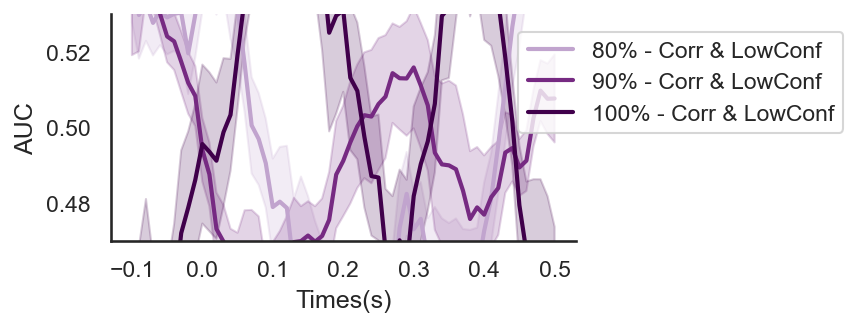

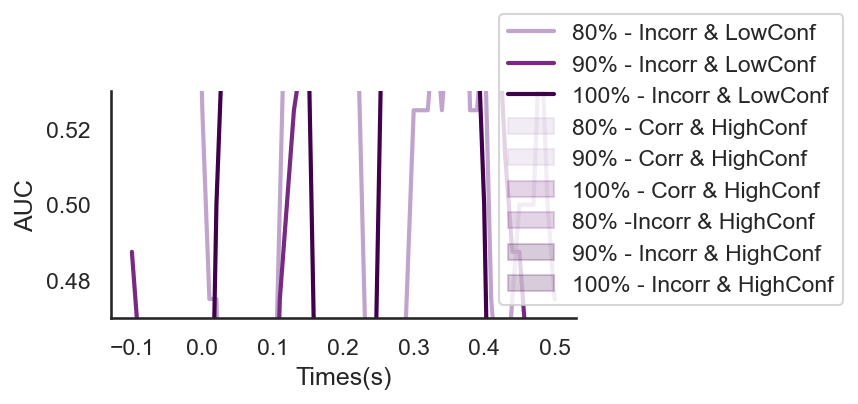

In [428]:
# Convert lists to numpy arrays
results_group = np.asarray(results_group)
predicted_probs_omi_group = np.asarray(predicted_probs_omi_group)

print('Shape of the results: ', results_group.shape)

# if the labels reversed then changee the plotnames
if reversedLabels == True:
    for i in range(strt, end):
        plot_labels.append(plot_labels[i]+'_invertedLabels')
else:
    print('No reversed labels!')


#for a in range(len(plot_file_suf)):
#print('ind: ', a)

if reversedLabels == False:
    plotname = figuresFolder + 'MVPA_GroupLevel_TestOmiScores_all_' +  sensors + '_' + task_name + '_' + str(w[0]) + '_' + str(w[1]) + "_sm_" + task_name+ "_opt_c.png"
else:
    plotname = figuresFolder + 'MVPA_GroupLevel_TestOmiScores_all_' +  sensors + '_' + task_name + '_' + str(w[0]) + '_' + str(w[1]) + "_sm_" + task_name+ "_rev.png"

# If too many curves exist, plot them in two separate files
if results_group.shape[1] > 3 and results_group.shape[1] % 3 == 0:
     
    plotname_1 = plotname[:-4] + "_1.png"   
    plot_conditions(results_group[:,:3,:], w, epochs[0].times[: tlim], 'AUC', plotname_1, labels=plot_labels[:3], 
                    smooth=True, isPredLevel=False, fvalues=None)
    
    plotname_2 = plotname[:-4] + "_2.png"
    plot_conditions(results_group[:,3:,:], w, epochs[0].times[: tlim], 'AUC', plotname_2, labels=plot_labels[3:], 
                    smooth=True, isPredLevel=False, fvalues=None)
    
else:
    plot_conditions(results_group, w, epochs[0].times[: tlim], 'AUC', plotname, labels=plot_labels, 
                smooth=True, isPredLevel=False, fvalues=None)


In [429]:
# save the group level results in np files 
# task_name = #"all_predLevel" #'all_incorrVScorr'# 'all_conf' #behavior_conf #behavior_conf_pred
if task_name == 'all_predLevel':
    filename_tmp_8 = results_folder + 'omi_' + str(8) + '_data=' + str(tmin) + '_' + str(tmax)
    filename_tmp_9 = results_folder + 'omi_' + str(9) + '_data=' + str(tmin) + '_' + str(tmax)
    filename_tmp_10 = results_folder + 'omi_' + str(10) + '_data=' + str(tmin) + '_' + str(tmax)
    
    if reversedLabels == True:
        filename_tmp_8  = filename_tmp_8 + '_inverted.npy'
        filename_tmp_9  = filename_tmp_9 + '_inverted.npy'
        filename_tmp_10  = filename_tmp_10 + '_inverted.npy'
    else:
        filename_tmp_8  = filename_tmp_8 + '.npy'
        filename_tmp_9  = filename_tmp_9 + '.npy'
        filename_tmp_10  = filename_tmp_10 + '.npy'
    
    np.save(filename_tmp_8, results_group[:,0,:])
    print('saving first results to ', filename_tmp_8)
    np.save(filename_tmp_9, results_group[:,1,:])
    np.save(filename_tmp_10, results_group[:,2,:])
    
elif task_name == 'all_incorrVScorr':
    filename_tmp_c = results_folder + 'omi_corr_data=' + str(tmin) + '_' + str(tmax)
    filename_tmp_i = results_folder + 'omi_incorr_data=' + str(tmin) + '_' + str(tmax)
    
    if reversedLabels == True:
        filename_tmp_c  = filename_tmp_c + '_inverted.npy'
        filename_tmp_i  = filename_tmp_i + '_inverted.npy'
    else:
        filename_tmp_c  = filename_tmp_c + '.npy'
        filename_tmp_i  = filename_tmp_i + '.npy'
    
    np.save(filename_tmp_c, results_group[:,0,:])
    print('saving first results to ', filename_tmp_c)
    np.save(filename_tmp_i, results_group[:,1,:])
    
elif task_name == 'all_conf':
    filename_tmp_l = results_folder + 'omi_low_data=' + str(tmin) + '_' + str(tmax)
    filename_tmp_h = results_folder + 'omi_high_data=' + str(tmin) + '_' + str(tmax)
    
    if reversedLabels == True:
        filename_tmp_l  = filename_tmp_l + '_inverted.npy'
        filename_tmp_h  = filename_tmp_h + '_inverted.npy'
    else:
        filename_tmp_l  = filename_tmp_l + '.npy'
        filename_tmp_h  = filename_tmp_h + '.npy'
    
    np.save(filename_tmp_l, results_group[:,0,:])
    print('saving first results to ', filename_tmp_l)
    np.save(filename_tmp_h, results_group[:,1,:])
    
    
    
elif task_name == 'conf_pred':
    filename_tmp_l8 = results_folder + 'omi_low_8_data=' + str(tmin) + '_' + str(tmax)
    filename_tmp_l9 = results_folder + 'omi_low_9_data=' + str(tmin) + '_' + str(tmax)
    filename_tmp_l10 = results_folder + 'omi_low_10_data=' + str(tmin) + '_' + str(tmax)
    
    filename_tmp_h8 = results_folder + 'omi_high_8_data=' + str(tmin) + '_' + str(tmax)
    filename_tmp_h9 = results_folder + 'omi_high_9_data=' + str(tmin) + '_' + str(tmax)
    filename_tmp_h10 = results_folder + 'omi_high_10_data=' + str(tmin) + '_' + str(tmax)

    
    if reversedLabels == True:
        filename_tmp_l8 = filename_tmp_l8 + '_inverted.npy'
        filename_tmp_h8 = filename_tmp_h8 + '_inverted.npy'
        
        filename_tmp_l9 = filename_tmp_l9 + '_inverted.npy'
        filename_tmp_h9 = filename_tmp_h9 + '_inverted.npy'
        
        filename_tmp_l10 = filename_tmp_l10 + '_inverted.npy'
        filename_tmp_h10 = filename_tmp_h10 + '_inverted.npy'
    else:
        filename_tmp_l8 = filename_tmp_l8 + '.npy'
        filename_tmp_h8 = filename_tmp_h8 + '.npy'
        
        filename_tmp_l9 = filename_tmp_l9 + '.npy'
        filename_tmp_h9 = filename_tmp_h9 + '.npy'
        
        filename_tmp_l10 = filename_tmp_l10 + '.npy'
        filename_tmp_h10 = filename_tmp_h10 + '.npy'
    
    np.save(filename_tmp_l8, results_group[:,0,:])
    print('saving first results to ', filename_tmp_l8)
    np.save(filename_tmp_l9, results_group[:,1,:])
    np.save(filename_tmp_l10, results_group[:,2,:])
        
    np.save(filename_tmp_h8, results_group[:,3,:])
    np.save(filename_tmp_h9, results_group[:,4,:])
    np.save(filename_tmp_h10, results_group[:,5,:])
    
    
    
elif task_name == 'behavior_conf':
    filename_tmp_cl = results_folder + 'omi_corr_low_data=' + str(tmin) + '_' + str(tmax)
    filename_tmp_ch = results_folder + 'omi_corr_high_data=' + str(tmin) + '_' + str(tmax)
    filename_tmp_il = results_folder + 'omi_incorr_low_data=' + str(tmin) + '_' + str(tmax)
    filename_tmp_ih = results_folder + 'omi_incorr_high_data=' + str(tmin) + '_' + str(tmax)
    
    if reversedLabels == True:
        filename_tmp_cl  = filename_tmp_cl + '_inverted.npy'
        filename_tmp_ch  = filename_tmp_ch + '_inverted.npy'
        filename_tmp_il  = filename_tmp_il + '_inverted.npy'
        filename_tmp_ih  = filename_tmp_ih + '_inverted.npy'
    else:
        filename_tmp_cl  = filename_tmp_cl + '.npy'
        filename_tmp_ch  = filename_tmp_ch + '.npy'
        filename_tmp_il  = filename_tmp_il + '.npy'
        filename_tmp_ih  = filename_tmp_ih + '.npy'
    
    np.save(filename_tmp_cl, results_group[:,0,:])
    print('saving first results to ', filename_tmp_cl)
    np.save(filename_tmp_ch, results_group[:,1,:])
    np.save(filename_tmp_il, results_group[:,2,:])
    np.save(filename_tmp_ih, results_group[:,3,:])
    
    
elif task_name == 'behavior_conf_pred':
    filename_tmp_cl_8 = results_folder + 'omi_corr_low_data_8=' + str(tmin) + '_' + str(tmax)
    filename_tmp_cl_9 = results_folder + 'omi_corr_low_data_9=' + str(tmin) + '_' + str(tmax)
    filename_tmp_cl_10 = results_folder + 'omi_corr_low_data_10=' + str(tmin) + '_' + str(tmax)
    
    filename_tmp_ch_8 = results_folder + 'omi_corr_high_data_8=' + str(tmin) + '_' + str(tmax)
    filename_tmp_ch_9 = results_folder + 'omi_corr_high_data_9=' + str(tmin) + '_' + str(tmax)
    filename_tmp_ch_10 = results_folder + 'omi_corr_high_data_10=' + str(tmin) + '_' + str(tmax)
    
    filename_tmp_il_8 = results_folder + 'omi_incorr_low_data_8=' + str(tmin) + '_' + str(tmax)
    filename_tmp_il_9 = results_folder + 'omi_incorr_low_data_9=' + str(tmin) + '_' + str(tmax)
    filename_tmp_il_10 = results_folder + 'omi_incorr_low_data_10=' + str(tmin) + '_' + str(tmax)
    
    filename_tmp_ih_8 = results_folder + 'omi_incorr_high_data_8=' + str(tmin) + '_' + str(tmax)
    filename_tmp_ih_9 = results_folder + 'omi_incorr_high_data_9=' + str(tmin) + '_' + str(tmax)
    filename_tmp_ih_10 = results_folder + 'omi_incorr_high_data_10=' + str(tmin) + '_' + str(tmax)
    
    if reversedLabels == True:
        filename_tmp_cl_8  = filename_tmp_cl_8 + '_inverted.npy'
        filename_tmp_cl_9  = filename_tmp_cl_9 + '_inverted.npy'
        filename_tmp_cl_10  = filename_tmp_cl_10 + '_inverted.npy'
        
        filename_tmp_ch_8  = filename_tmp_ch_8 + '_inverted.npy'
        filename_tmp_ch_9  = filename_tmp_ch_9 + '_inverted.npy'
        filename_tmp_ch_10  = filename_tmp_ch_10 + '_inverted.npy'
        
        filename_tmp_il_8  = filename_tmp_il_8 + '_inverted.npy'
        filename_tmp_il_9  = filename_tmp_il_9 + '_inverted.npy'
        filename_tmp_il_10  = filename_tmp_il_10 + '_inverted.npy'
        
        filename_tmp_ih_8  = filename_tmp_ih_8 + '_inverted.npy'
        filename_tmp_ih_9  = filename_tmp_ih_9 + '_inverted.npy'
        filename_tmp_ih_10  = filename_tmp_ih_10 + '_inverted.npy'
        
    else:
        filename_tmp_cl_8  = filename_tmp_cl_8 + '.npy'
        filename_tmp_cl_9  = filename_tmp_cl_9 + '.npy'
        filename_tmp_cl_10  = filename_tmp_cl_10 + '.npy'
        
        filename_tmp_ch_8  = filename_tmp_ch_8 + '.npy'
        filename_tmp_ch_9  = filename_tmp_ch_9 + '.npy'
        filename_tmp_ch_10  = filename_tmp_ch_10 + '.npy'
        
        filename_tmp_il_8  = filename_tmp_il_8 + '.npy'
        filename_tmp_il_9  = filename_tmp_il_9 + '.npy'
        filename_tmp_il_10  = filename_tmp_il_10 + '.npy'
        
        filename_tmp_ih_8  = filename_tmp_ih_8 + '.npy'
        filename_tmp_ih_9  = filename_tmp_ih_9 + '.npy'
        filename_tmp_ih_10  = filename_tmp_ih_10 + '.npy'
    
    np.save(filename_tmp_cl_8, results_group[:,0,:])
    print('saving first results to ', filename_tmp_cl_8)
    np.save(filename_tmp_cl_9, results_group[:,1,:])
    np.save(filename_tmp_cl_10, results_group[:,2,:])
    
    np.save(filename_tmp_il_8, results_group[:,3,:])
    np.save(filename_tmp_il_9, results_group[:,4,:])
    np.save(filename_tmp_il_10, results_group[:,5,:])
    
    np.save(filename_tmp_ch_8, results_group[:,6,:])
    np.save(filename_tmp_ch_9, results_group[:,7,:])
    np.save(filename_tmp_ch_10, results_group[:,8,:])
            
    np.save(filename_tmp_ih_8, results_group[:,9,:])
    np.save(filename_tmp_ih_9, results_group[:,10,:])
    np.save(filename_tmp_ih_10, results_group[:,11,:])
    
else:
    print('Nothing saved!')


saving first results to  ..\Results\Data=-0.1_0.6\omi_corr_low_data_8=-0.1_0.6.npy
